In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from test_utils import test

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    
    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
test(build_k_indices)

✅ Your `build_k_indices` passes some basic tests.


For the following cross_validation( ) function you need to implement, you can help yourselves of the build_poly( ) and ridge_regression( ) functions that you implemented in lab 3. Copy paste the code in the build_polynomial.py and ridge_regression.py files, they should pass the two following tests.

In [5]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly


test(build_poly)
test(ridge_regression)

✅ Your `build_poly` passes some basic tests.
✅ Your `ridge_regression` passes some basic tests.


In [6]:
from costs import compute_mse

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression for a fold corresponding to k_indices
    
    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    indices = k_indices[k]
    
    # Get the test sets
    x_te = x[indices]
    y_te = y[indices]

    # Get the training sets
    x_tr = np.delete(x, indices)
    y_tr = np.delete(y, indices)

    # ***************************************************
    # INSERT YOUR CODE HERE
    # form data with polynomial degree: TODO
    # ***************************************************
    
    x_te = build_poly(x_te, degree)
    x_tr = build_poly(x_tr, degree)

    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************

    w = ridge_regression(y_tr, x_tr, lambda_)

    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************

    loss_tr = np.sqrt(2*compute_mse(y_tr, x_tr, w))
    loss_te = np.sqrt(2*compute_mse(y_te, x_te, w))

    return loss_tr, loss_te


In [7]:
# can lead to a numerical error if you use an older version than Python 3.9 
test(cross_validation)  

✅ Your `cross_validation` passes some basic tests.


In [8]:
a = [[1, 1], [2, 5]]
np.array(a).mean(axis=0)

array([1.5, 3. ])

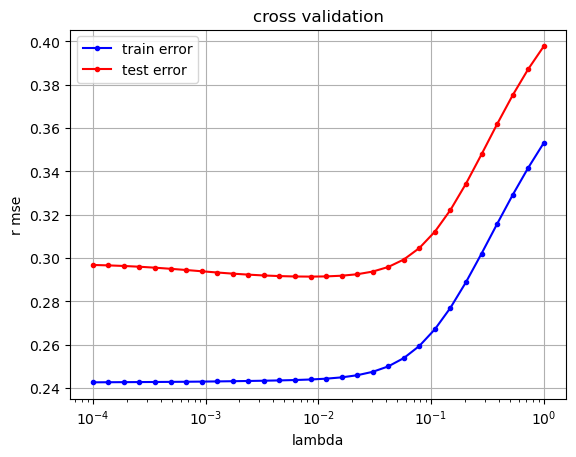

In [9]:
from plots import cross_validation_visualization

def cross_validation_demo(degree, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.
    
    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """
    
    seed = 12
    degree = degree
    k_fold = k_fold
    lambdas = lambdas
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation over lambdas: TODO
    # ***************************************************
    for lambda_ in lambdas:
        run = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            run.append([loss_tr, loss_te])
        losses = np.array(run).mean(axis=0)
        rmse_tr.append(losses[0])
        rmse_te.append(losses[1])

    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

    arg_min_rmse = np.argmin(rmse_te)
    best_lambda = lambdas[arg_min_rmse]
    best_rmse = rmse_te[arg_min_rmse]

    #print("For polynomial expansion up to degree %.f, the choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f" % (degree, best_lambda, best_rmse))
    
    return best_lambda, best_rmse


best_lambda, best_rmse = cross_validation_demo(7, 4, np.logspace(-4, 0, 30))

Your output should look like this for seed = 12, degree = 7 and k_fold = 4:

![alt text](cross_validation2.png)

You can play around with the number of folds and the degree of your polynomial expansion.

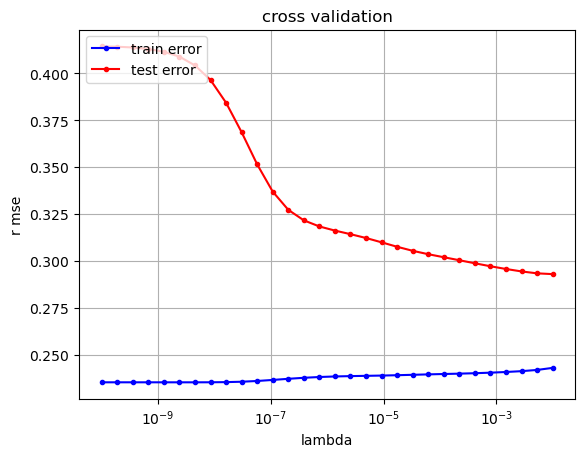

In [10]:
best_lambda, best_rmse = cross_validation_demo(10, 4, np.logspace(-10, -2,  30))

In the previous task we did a grid search over several values of $\lambda$ for a fixed degree. We can also perform a grid search amongst $\lambda$ and degrees simultaneously:

In [11]:
def best_degree_selection(degrees, k_fold, lambdas, seed = 1):
    """cross validation over regularisation parameter lambda and degree.
    
    Args:
        degrees: shape = (d,), where d is the number of degrees to test 
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_degree : integer, value of the best degree
        best_lambda : scalar, value of the best lambda
        best_rmse : value of the rmse for the couple (best_degree, best_lambda)
        
    >>> best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
    (7, 0.004520353656360241, 0.28957280566456634)
    """
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation over degrees and lambdas: TODO
    # ***************************************************
    best_lambdas = []
    best_rmses = []
    for degree in degrees:
        rms = []
        for lambda_ in lambdas:
            rmses = []
            for k in range(k_fold):
                _, rmse_te = cross_validation(y, x, k_indices, k, lambda_, degree)
                rmses.append(rmse_te)
            rms.append(np.mean(rmses))
    
        min = np.array(rms).argmin()
        best_lambdas.append(lambdas[min])
        best_rmses.append(rms[min])
    
    min = np.array(best_rmses).argmin()
    best_degree = degrees[min]
    best_lambda = best_lambdas[min]
    best_rmse = best_rmses[min]

    return best_degree, best_lambda, best_rmse

In [12]:
# can lead to a numerical error if you use an older version than Python 3.9 
test(best_degree_selection)

best_degree, best_lambda, best_rmse = best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
print("The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f." % (best_rmse, best_degree, best_lambda))

❌ The are some issues with your implementation of `best_degree_selection`:
**********************************************************************
File "__main__", line 13, in best_degree_selection
Failed example:
    best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
Expected:
    (7, 0.004520353656360241, 0.28957280566456634)
Got:
    (7, 0.004520353656360241, 0.28765503884861593)
**********************************************************************
The best rmse of 0.288 is obtained for a degree of 7 and a lambda of 0.00452.


## Bias-Variance Decomposition

In [32]:
#true function we want to learn
def f_star(x):
    return x**3 - x**2 + 0.5

# plotting function for f_star
def plot_fstar(ax):
    xvals = np.arange(-1, 1, 0.01)
    ax.plot(xvals, f_star(xvals),  linestyle = '--', color = 'k', label = 'f_star')
    ax.set_ylim(-2, 2)

In [44]:
# helper plot function
def plot_poly(x, y, weights, degree, ax, alpha = 0.3):
    xvals = np.arange(-1, 1, 0.01)  
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color = 'orange', alpha = alpha)
    ax.scatter(x, y, color='b', alpha = alpha, s = 10) 
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Polynomial degree " + str(degree))
    ax.set_ylim(-1, 2)

# helper plot function 
def plot_f(weights, degree, ax, label = None, color='orange', alpha=1):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color = color, alpha = alpha, label = label)
    ax.set_ylim(-1, 2)

Implement the following function: for 15 random datapoints, it finds the optimal fit (using the least square formula, with no regularisation λ) for a polynomial expansion of degree 1, 3 and 6.

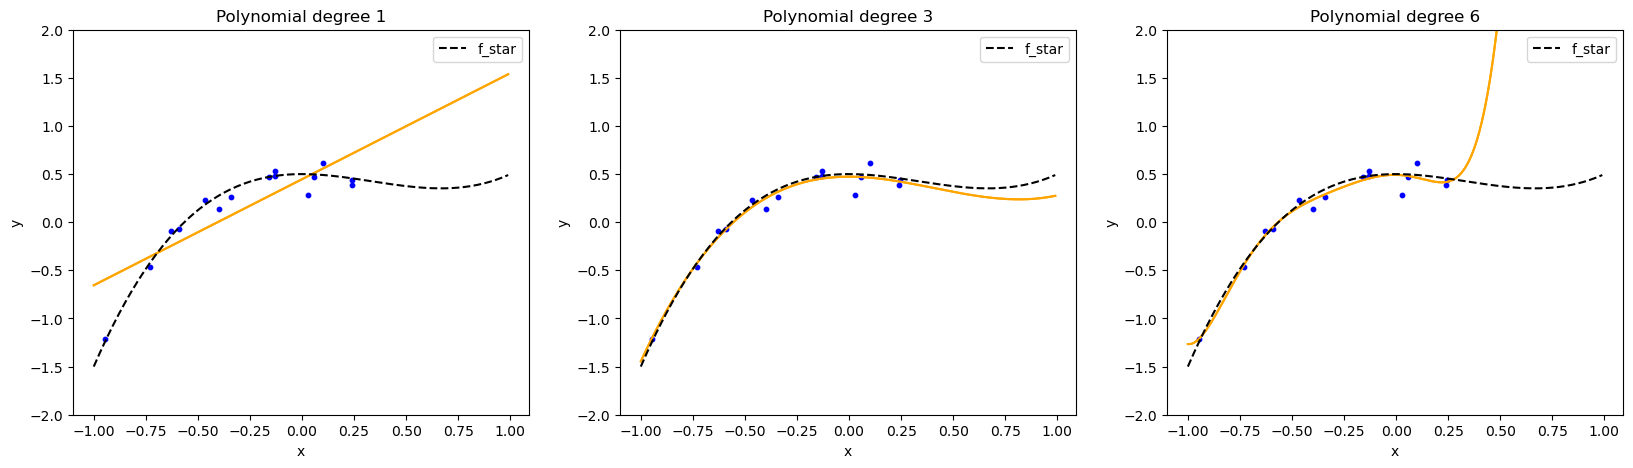

In [41]:
from least_squares import least_squares

def bias_variance_one_seed(sigma, degrees, seed):
    """One run of the optimal fit for 15 random points and different polynomial expansion degrees.
    
    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
        seed: integer, random see
    Returns:
    """
    
    
    # we will generate 15 random datapoints from the [-1, 1] uniform distribuion
    num_data = 15
    np.random.seed(seed)  # set random seed for reproducibility
    xs = np.random.uniform(-1, 1, num_data)
    # the outputs will be f_star(x) + some random gaussian noise of variance sigma**2
    ys = f_star(xs) + sigma * np.random.randn(num_data).T
    
    fig, axs = plt.subplots(1, 3, figsize = (20, 5))
    for index_degree, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        xs_poly = build_poly(xs, degree)
        w, _ = least_squares(ys, xs_poly)
        plot_f(w, degree, ax=axs[index_degree])
        plot_poly(xs, ys, w, degree, axs[index_degree], 1)
        
        plot_fstar(axs[index_degree])
        axs[index_degree].legend()
    plt.show()

bias_variance_one_seed(0.1, [1, 3, 6], seed = 2)

Your output should ressemble (for seed = 2) to this: 
![alt text](bias_variance_one_run.png)

Now to illustrate the bias variance tradeoff we will repeat many times the previous experiment but using a different random seed each time. We also plot (in plain black) the mean of all the orange functions obtained.

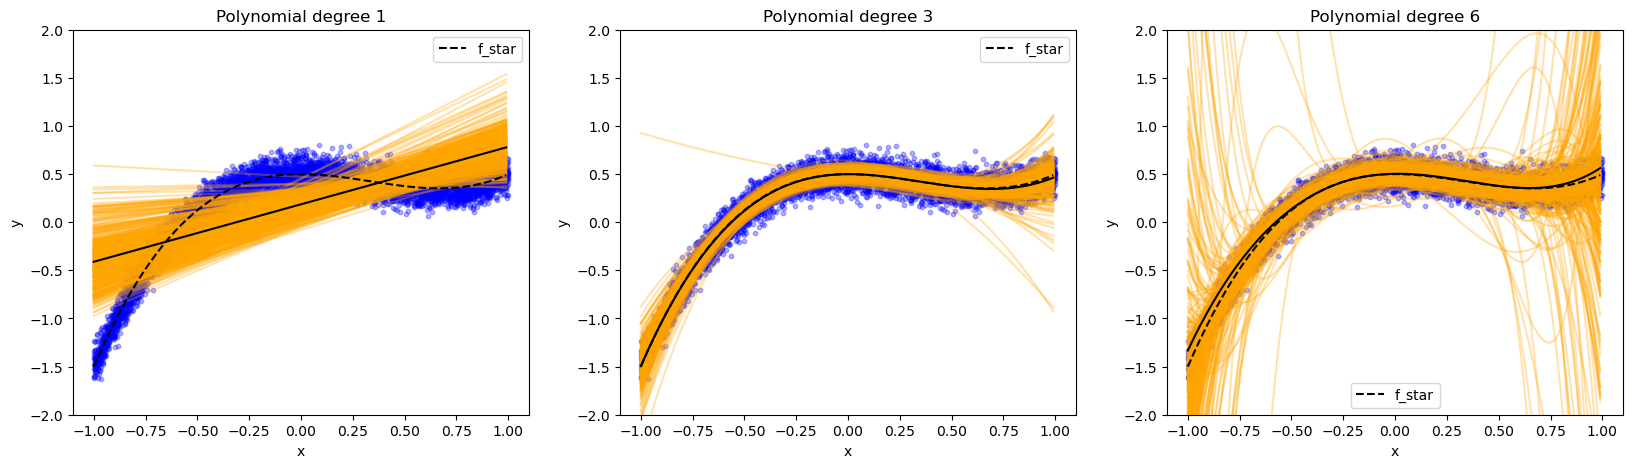

In [51]:
def bias_variance_demo(sigma, degrees):
    """Illustration of the bias-variance tradeoff.
    
    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
    Returns:
    """
    # define parameters
    seeds = range(400)  # number of runs
    num_data = 15

    
    fig, axs = plt.subplots(1, 3, figsize = (20, 5))
    for index_degree, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        ws = []
        for seed in seeds:
            np.random.seed(seed)
            xs = np.random.uniform(-1, 1, num_data)
            # the outputs will be f_star(x) + some random gaussian noise of variance sigma**2
            ys = f_star(xs) + sigma * np.random.randn(num_data).T
            xs_poly = build_poly(xs, degree)
            w, _ = least_squares(ys, xs_poly)
            ws.append(w)
            plot_f(w, degree, ax=axs[index_degree], alpha=0.02)
            plot_poly(xs, ys, w, degree, axs[index_degree])
        plot_f(np.mean(ws, axis=0), degree, ax=axs[index_degree], color='black')
        plot_fstar(axs[index_degree])
        axs[index_degree].legend()
    plt.show()

bias_variance_demo(0.1, [1, 3, 6])

Your output should ressemble to this: 
![alt text](bias_variance.png)